### Toxic Comment Classification Challenge

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
import numpy as np 
import pandas as pd
import string
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer 
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from textblob import TextBlob
from nltk.stem.wordnet import WordNetLemmatizer 
import gensim

In [7]:
df = pd.read_csv('/Users/lipinyuan/Downloads/MachineLearning/train.csv')

### Data Overview

In [9]:
df.head(5)
df.describe()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Add Variable

In [10]:
rowsums=df.iloc[:,2:].sum(axis=1)
df['clean']=(rowsums==0) *1

In [11]:
#Create indirect features to help compensate for the loss of information when cleaning the dataset:

#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [12]:
#Add 3 "emotional" puncs
#count of !
df['count_!']=df["comment_text"].apply(lambda x: len([w for w in x if w == "!"]))
#count of ?
df['count_?']=df["comment_text"].apply(lambda x: len([w for w in x if w == "?"]))
#count of ^
df['count_^']=df["comment_text"].apply(lambda x: len([w for w in x if w == "^"]))

In [13]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
# Cap word percent in each comment
df['cap_percent']=df["count_words_upper"]*100/df['count_word']
#remove cap count after calculate the percengtage
df.drop('count_words_upper', axis=1, inplace=True)

In [14]:
df['sentiment'] = df['comment_text'].apply(lambda x : TextBlob(x).sentiment)

In [15]:
df['polarity'] = df['sentiment'].apply(lambda x : x[0])
df['subjective'] = df['sentiment'].apply(lambda x : x[1])
df.drop('sentiment', axis=1, inplace=True)

In [16]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,count_sent,...,count_unique_word,count_letters,mean_word_len,count_!,count_?,count_^,word_unique_percent,cap_percent,polarity,subjective
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,2,...,41,264,5.162791,0,1,0,95.348837,4.651163,0.136364,0.454545
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,1,...,17,112,5.588235,1,0,0,100.000000,5.882353,0.287500,0.550000
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,1,...,39,233,4.571429,0,0,0,92.857143,0.000000,0.160000,0.406667
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,5,...,82,622,4.486726,0,0,0,72.566372,4.424779,0.200000,0.301042
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,1,...,13,67,4.230769,0,1,0,100.000000,0.000000,0.000000,0.000000


### Data Cleaning<br>


In [17]:
df['comment_text'].iloc[10100]

'"\n\n would like to nominate you to become an administrator. Please visit Wikipedia:Requests for adminship to see what this process entails, and then contact Dylan620 to accept or decline the nomination. A page  for your nomination at Wikipedia:Requests for adminship/Cyclonebiskit . If you accept the nomination, you must state and sign your acceptance. You may also choose to make a statement and/or answer the optional questions to supplement the information your nominator has given. Once you are satisfied with the page, you may post your nomination for discussion, or request that your nominator do so.\n\'\'\'\'\'\' (chat, work, ping, ) "'

In [18]:
corpus = df.comment_text

In [19]:
corpus.head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [20]:
tokenizer=TweetTokenizer()
lem = WordNetLemmatizer()
eng_stopwords = set(stopwords.words("english"))
pun = set(string.punctuation)

In [21]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    # Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    # remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    # remove usernames
    comment=re.sub("\[\[.*\]","",comment)
 
    
    # Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    # remove stopwords and punctuation
    words = [lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    words = [w for w in words if not w in pun]
    
    clean_sent=" ".join(words)
    
    return(clean_sent)

In [22]:
clean_corpus = corpus.apply(lambda x :clean(x))

In [23]:
df['comment'] = clean_corpus

In [24]:
import json

with open('words_dictionary.json') as f:
    dict_words = json.load(f)
    
def get_readability(line):
    words = line.split(' ')
    word_len = len(words)
    dict_word_len = 0
    for word in words:
        if word in dict_words:
            dict_word_len += 1
    return dict_word_len / (word_len + 0.0)
    
df['readability'] = df['comment'].apply(lambda x : get_readability(x))

In [25]:
df.to_csv('datadata.csv',sep=',')

In [26]:
df['comment'].iloc[10010]

'archivingi notice post comment archive userboxes prevent future rogue admins know already exist wikipedia userboxes archive 1 way page huge could crash browser war'

### Using variables only
### Split dataset

In [27]:
msk = np.random.rand(len(df)) < 0.7
train = df[msk]
test = df[~msk]

In [28]:
x_train = pd.concat([train.iloc[:,9:21],train.iloc[:,22]], axis=1)
x_test = pd.concat([test.iloc[:,9:21],test.iloc[:,22]], axis=1)
y_train = train.iloc[:,2:9]
y_test= test.iloc[:,2:9]

In [29]:
x_train.head()
y_train.head()

,count_sent,count_word,count_unique_word,count_letters,mean_word_len,count_!,count_?,count_^,word_unique_percent,cap_percent,polarity,subjective,readability
2,1,42,39,233,4.571429,0,0,0,92.857143,0.000000,0.16,0.406667,0.954545
3,5,113,82,622,4.486726,0,0,0,72.566372,4.424779,0.20,0.301042,0.865385
4,1,13,13,67,4.230769,0,1,0,100.000000,0.000000,0.00,0.000000,0.833333
6,1,8,8,44,4.625000,0,0,0,100.000000,100.000000,0.00,0.000000,0.750000
7,1,20,20,115,4.750000,0,0,0,100.000000,0.000000,0.00,0.000000,0.857143


,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1
6,1,1,1,0,1,0,0
7,0,0,0,0,0,0,1


### Naive bayes  (multi-lable)

In [33]:
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import LabelPowerset
from sklearn.metrics import accuracy_score

In [34]:
classifier = LabelPowerset(GaussianNB())

In [35]:
len(y_train)

111424

In [36]:
classifier.fit(x_train, y_train)

LabelPowerset(classifier=GaussianNB(priors=None), require_dense=[True, True])

In [37]:
predictions = classifier.predict(x_test)

In [38]:
accuracy_score(y_test,predictions)

0.28292520821650363

### Decision Tree

In [39]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [40]:
dt = DecisionTreeClassifier(random_state=0)

In [41]:
dt.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [42]:
predictions = dt.predict(x_test)

In [43]:
cross_val_score(dt,y_test,predictions,cv = 10)

array([0.8874351 , 0.88369678, 0.88307373, 0.87850467, 0.88203531,
       0.88390447, 0.88452752, 0.87931034, 0.88969672, 0.87474034])

In [44]:
accuracy_score(y_test,predictions)

0.8284005233970964

### KNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier

In [109]:
knn = KNeighborsClassifier(n_jobs=-1)

In [110]:
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

In [111]:
print(knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')


In [48]:
pred = knn.predict(x_test)

In [49]:
accuracy_score(y_test, pred)

0.8783101750887906

In [112]:
%%time

parameters = {'n_neighbors': [1,3,5,7,9,11]}

knn_new = GridSearchCV(knn, parameters, n_jobs=-1)
knn_new.fit(x_train, y_train)

results_knn = pd.DataFrame(knn_new.cv_results_)

CPU times: user 14.8 s, sys: 1.53 s, total: 16.3 s
Wall time: 3min 23s


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Applications/anaconda3/lib/py

In [113]:
results_knn.sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
5,18.883973,4.964113,0.895076,0.897948,11,{'n_neighbors': 11},1,0.894459,0.898670,0.894402,0.898025,0.896368,0.897150,3.708809,1.914847,0.000913,0.000623
4,26.606798,5.561869,0.894341,0.897984,9,{'n_neighbors': 9},2,0.893894,0.898912,0.893702,0.897877,0.895426,0.897164,1.846979,1.217636,0.000771,0.000718
3,28.659935,5.769593,0.892546,0.898469,7,{'n_neighbors': 7},3,0.891632,0.899114,0.892087,0.898456,0.893918,0.897837,4.384543,1.034540,0.000988,0.000522
2,23.486212,5.350614,0.888992,0.899757,5,{'n_neighbors': 5},4,0.888294,0.900205,0.888021,0.899546,0.890660,0.899519,3.174887,1.081617,0.001185,0.000317
1,24.608451,3.763601,0.879066,0.906021,3,{'n_neighbors': 3},5,0.877820,0.906545,0.879513,0.905779,0.879863,0.905739,1.777992,0.342727,0.000892,0.000371
0,28.701792,3.649053,0.835780,0.995652,1,{'n_neighbors': 1},6,0.834365,0.995329,0.835815,0.995531,0.837161,0.996096,2.695133,0.686871,0.001142,0.000325


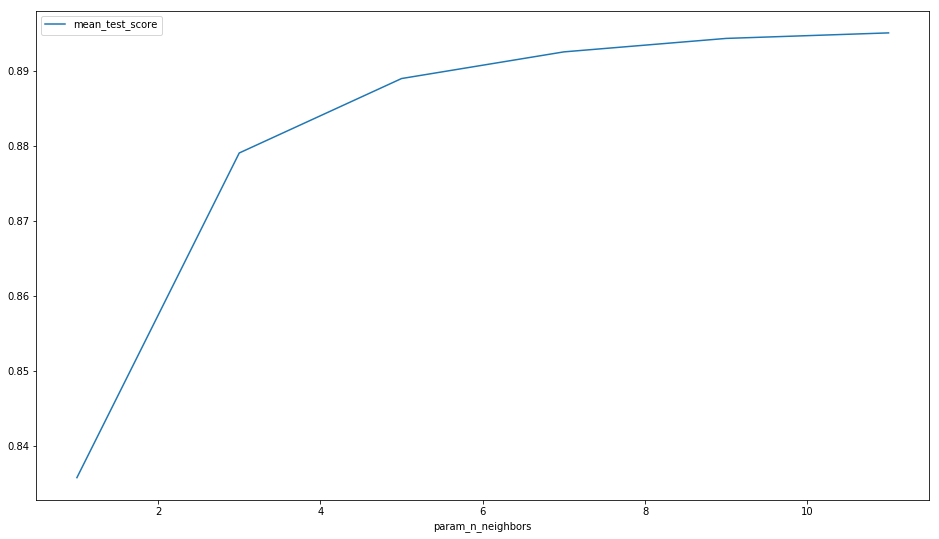

In [114]:
results_knn.plot('param_n_neighbors','mean_test_score')

### MLPClassifier Neural Network

In [116]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [117]:
mlp = MLPClassifier(random_state = 0)

In [118]:
mlp.fit(x_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [119]:
predictions = mlp.predict(x_test)

In [123]:
parameters = {'hidden_layer_sizes' : [(50,), (100,), (784,), (50,50), (100,100), (784,784), (50,50,50), (100,100,100)] }

mlp_clf= GridSearchCV(mlp, parameters, n_jobs=-1)

In [125]:
mlp_clf.fit(x_train, y_train)

results = pd.DataFrame(mlp_clf.cv_results_)
results.sort_values('mean_test_score', ascending = False)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


GridSearchCV(cv=None, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(50,), (100,), (784,), (50, 50), (100, 100), (784, 784), (50, 50, 50), (100, 100, 100)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Applications/anaconda3/lib/py

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_hidden_layer_sizes,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
5,2370.170144,4.667448,0.895956,0.896759,"(784, 784)","{'hidden_layer_sizes': (784, 784)}",1,0.894109,0.897028,0.896126,0.895952,0.897633,0.897298,958.870464,0.727210,0.001444,0.000581
6,139.655514,0.484619,0.893003,0.893241,"(50, 50, 50)","{'hidden_layer_sizes': (50, 50, 50)}",2,0.892736,0.894577,0.892922,0.892977,0.893352,0.892169,42.619194,0.162745,0.000258,0.001001
7,730.990834,0.745722,0.892994,0.894035,"(100, 100, 100)","{'hidden_layer_sizes': (100, 100, 100)}",3,0.892844,0.897229,0.893083,0.892883,0.893056,0.891994,730.667333,0.333117,0.000107,0.002287
2,179.005455,1.517615,0.892887,0.893362,"(784,)","{'hidden_layer_sizes': (784,)}",4,0.892440,0.894147,0.894079,0.895212,0.892141,0.890729,20.045628,0.279575,0.000852,0.001912
0,12.268679,0.103404,0.889476,0.889360,"(50,)","{'hidden_layer_sizes': (50,)}",5,0.888347,0.889664,0.887294,0.887282,0.892787,0.891133,4.704854,0.007060,0.002380,0.001586
3,63.504588,0.270331,0.887295,0.887192,"(50, 50)","{'hidden_layer_sizes': (50, 50)}",6,0.883770,0.884548,0.888587,0.888992,0.889529,0.888036,36.433187,0.060507,0.002522,0.001910
1,12.362223,0.151709,0.884064,0.883580,"(100,)","{'hidden_layer_sizes': (100,)}",7,0.869851,0.870574,0.896099,0.896140,0.886244,0.884025,6.174873,0.017561,0.010826,0.010442
4,122.133752,0.933897,0.847582,0.848053,"(100, 100)","{'hidden_layer_sizes': (100, 100)}",8,0.759141,0.759996,0.889583,0.890406,0.894025,0.893758,69.759722,0.618264,0.062565,0.062281


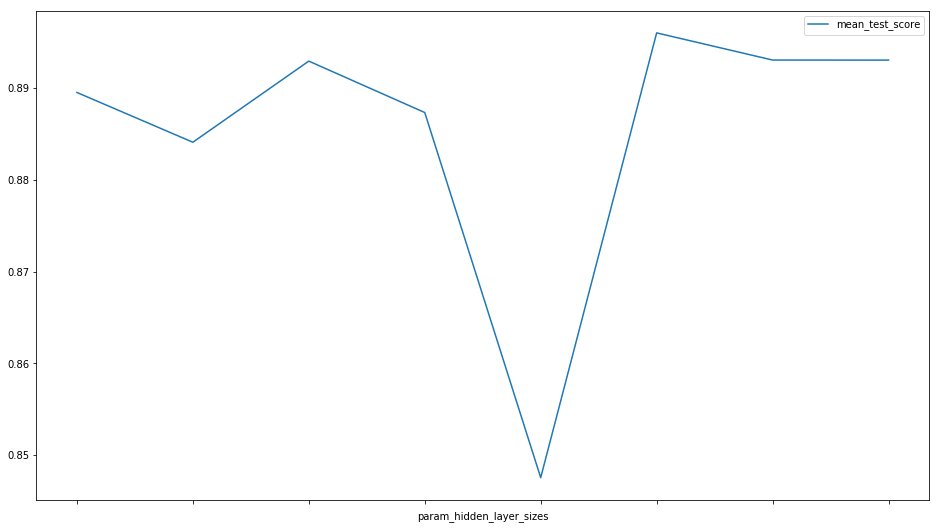

In [126]:
results.plot('param_hidden_layer_sizes','mean_test_score')

In [54]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.69      0.23      0.34      4679
          1       0.50      0.01      0.02       527
          2       0.65      0.12      0.20      2620
          3       0.00      0.00      0.00       151
          4       0.60      0.06      0.12      2422
          5       0.00      0.00      0.00       434
          6       0.92      0.99      0.95     43183

avg / total       0.86      0.82      0.81     54016



/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [55]:
accuracy_score(y_test,predictions)

0.8908135501692732

### Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [74]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [80]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

In [90]:
from sklearn.model_selection import GridSearchCV

In [82]:
rd = RandomForestClassifier(n_jobs=-1, random_state=0)

In [83]:
rd.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [84]:
predictions = rd.predict(x_test)

In [ ]:
acc_rf = accuracy_score(y_test,predictions)

In [86]:
print("Random forest accuracy: ",acc_rf)

Random forest accuracy:  0.8778532411157497


In [93]:
parameters = {'n_estimators': [10,20,40,60,80,100,120,140,160]}

In [99]:
%%time

rf = GridSearchCV(rd, parameters, n_jobs=-1)
rf.fit(x_train, y_train)

CPU times: user 2min 53s, sys: 8.07 s, total: 3min 1s
Wall time: 11min 32s


In [97]:
#rf

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 40, 60, 80, 100, 120, 140, 160]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [100]:
results = pd.DataFrame(rf.cv_results_)#grid_scores_

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Applications/anaconda3/lib/py

In [101]:
results.sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
8,112.320018,6.105012,0.893308,0.996540,160,{'n_estimators': 160},1,0.892574,0.996365,0.892572,0.996486,0.894779,0.996769,11.918389,1.806486,0.001040,0.000169
7,130.958221,9.187109,0.893219,0.996500,140,{'n_estimators': 140},2,0.892278,0.996311,0.892625,0.996500,0.894752,0.996688,7.983021,0.249758,0.001094,0.000154
6,125.174117,10.115261,0.893039,0.996450,120,{'n_estimators': 120},3,0.891928,0.996284,0.892652,0.996419,0.894537,0.996648,3.039219,1.925565,0.001100,0.000150
5,96.250928,8.409851,0.892806,0.996334,100,{'n_estimators': 100},4,0.891551,0.996163,0.892383,0.996311,0.894483,0.996527,5.165802,0.950402,0.001234,0.000149
4,67.327660,5.783450,0.892429,0.996208,80,{'n_estimators': 80},5,0.891524,0.996096,0.892033,0.996177,0.893729,0.996352,2.154519,0.579979,0.000943,0.000107
3,49.688991,3.705279,0.891567,0.995706,60,{'n_estimators': 60},6,0.890905,0.995584,0.891010,0.995625,0.892787,0.995908,0.797441,0.280499,0.000863,0.000144
2,34.065530,2.333143,0.890535,0.994198,40,{'n_estimators': 40},7,0.889640,0.993915,0.890095,0.994292,0.891872,0.994386,0.393092,0.108043,0.000963,0.000204
1,18.752189,1.270757,0.887448,0.988786,20,{'n_estimators': 20},8,0.886517,0.988288,0.887402,0.989109,0.888425,0.988961,0.695044,0.023022,0.000780,0.000357
0,11.880956,0.808569,0.879012,0.978613,10,{'n_estimators': 10},9,0.879113,0.978582,0.878140,0.978326,0.879782,0.978932,0.120081,0.060594,0.000674,0.000248


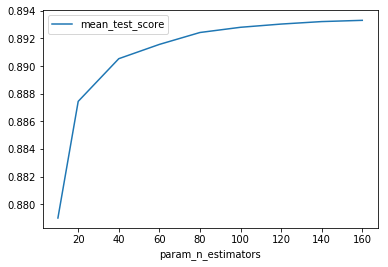

In [102]:
results.plot('param_n_estimators','mean_test_score')

In [103]:
plt.rcParams["figure.figsize"] = [16,9]

## Neural Network

In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
y = y_train

In [ ]:
list_sentences_train = train["comment"]
list_sentences_test = test['comment']

In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

In [143]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [148]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
inp = Input(shape=(maxlen, ))

In [149]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In [ ]:
accuracy_score(list_tokenized_test,predictions)